# Welcome to some of the cross validation tools in sklearn!

In [1]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split, cross_val_score #check these out wowow
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#start with some unnecessarily randomized data
x=np.random.uniform(-3, 3, (1000,2))*np.random.randn(1000,2)

#create a toy function for target that isn't exactly linear with respect to the data columns 
y= 5*x[:,0] + 0.9*x[:,1]**2 + 5*x[:,1] + 11 + 7*np.random.randn(1000) # irreducible error at the end

In [2]:
x[:10] # check what the feature array looks like

array([[ 8.91791566e-01, -1.20763896e-01],
       [ 8.31312045e-01, -8.75667885e-02],
       [ 2.03667232e-01, -2.53274927e+00],
       [-7.37457129e-01, -4.21122038e-02],
       [-3.26764274e+00, -5.33056788e+00],
       [-1.10306814e-01, -3.29265559e-01],
       [-8.44315013e-02,  8.93234392e-01],
       [ 1.13063658e+00, -1.42292028e-01],
       [-3.65299968e-03, -1.05236391e+00],
       [ 6.84344342e-01,  6.06376190e-02]])

In [3]:
y[:10] # now our target

array([12.3538751 , 22.88208486, -2.95638638, 11.12756745, -8.13082722,
        8.46579133, 19.48327131, 14.52033959,  5.76398385, 17.78198403])

In [4]:
# Let's create a true holdout data set, x_test, y_test.

test_size=0.25         #0.25 is the default anyway~
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=test_size)

# don't mess with x_test and y_test just yet folks! we could also hide these away somewhere by writing them to file or saving them elsewhere

In [5]:
# get indices for validation data

kf=KFold(n_splits=5)

#fit and evaluate one model k times over training data

linear_scores = []

# note that i'm calling the kfold chunks of data that aren't validation "train" which is so so similar 
# to the previous train holdout split we had earlier! 
for train, validation in kf.split(x_train,y_train):
    lin=LinearRegression()
    lin.fit(x_train[train],y_train[train])
    linear_scores.append(mean_squared_error(lin.predict(x_train[validation]),y_train[validation]))
    
print(np.mean(linear_scores))

87.00669857103354


That wasn't helpful at all. We aren't changing anything when we're running this to compare different types of models. :(

Let's think about some ways we have to change "the model"

Let's try adding in or subtracting features, maybe using our DOMAIN KNOWLEDGE of the function we built.#

In [6]:
kf=KFold(n_splits=5)

#fit and evaluate one model k times over training data

train_score_lists = [[],[],[],[]]
test_score_lists = [[],[],[],[]]

x0 = x_train[:,0].reshape(-1,1)
x1 = x_train[:,1].reshape(-1,1)
x0x1 = x_train
x0x1_x1sq = np.concatenate((x_train, (x_train[:,1]**2).reshape(-1,1)), axis=1) # adding a x1 squared term

x_list = [x0, x1, x0x1, x0x1_x1sq]
    
for train, validation in kf.split(x_train,y_train):
    for i in range(len(train_score_lists)):
        lin = LinearRegression()
        lin.fit(x_list[i][train],y_train[train])
        train_score_lists[i].append(mean_squared_error(lin.predict(x_list[i][train]),y_train[train]))
        test_score_lists[i].append(mean_squared_error(lin.predict(x_list[i][validation]),y_train[validation]))

print('Training k=5 Avg of Mean Squared Errors')
for score_list in train_score_lists:
    print(np.mean(score_list))
print('\nTest k=5 Avg of Mean Squared Errors')    
for score_list in test_score_lists:
    print(np.mean(score_list))

Training k=5 Avg of Mean Squared Errors
156.89655917585478
154.8785345008168
85.54780839952636
46.555276279895516

Test k=5 Avg of Mean Squared Errors
158.34323468901403
155.93555047817316
87.00669857103354
46.9181502710257


**Does it always have to be so tedious? Nah!** 

**Here comes cross_val_score**

In [7]:
for x_version in x_list:
    lin = LinearRegression()
    print(cross_val_score(lin, x_version, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    
# note this is negative mean squared error since sklearn is always working under the assumption higher score is better

-158.34323468901403
-155.93555047817316
-87.00669857103354
-46.9181502710257


If you need more options for scoring options: http://scikit-learn.org/stable/modules/model_evaluation.html

**Finally, if we're satisfied with all the cross-validating we've done we get to bring in our dear friend the holdout data for a final model evaluation. But remember, we generated a brand new feature for x_train that we never did for x_test, the holdout set!**

*Let's make sure we do any data transformations that we did to the training data on the test data.*

In [8]:
x_test_final = np.concatenate((x_test, (x_test[:,1]**2).reshape(-1,1)), axis=1) # adding new column for x1 squared

lin_final = LinearRegression()
lin_final.fit(x0x1_x1sq, y_train)

print(mean_squared_error(lin_final.predict(x_test_final), y_test))

43.684975232773176


# How does penalizing coefficients change the optimal coefficient values?

### Train-error and cost function with moderate Lasso constant added

Text(0.5,0,'Beta 1')

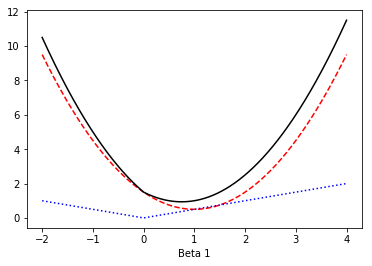

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

beta=np.linspace(-2,4,601)

lam=0.5
n_subplots=7

mse=(beta-1)**2+.5
lasso_penalty=lam*abs(beta)
lasso_cost=mse+lasso_penalty

plt.plot(beta,mse, c='r', linestyle='--')
plt.plot(beta,lasso_penalty, c='b', linestyle=':')
plt.plot(beta,lasso_cost, c='k')
plt.xlabel('Beta 1')

### Varying lambda to increase Lasso penalty

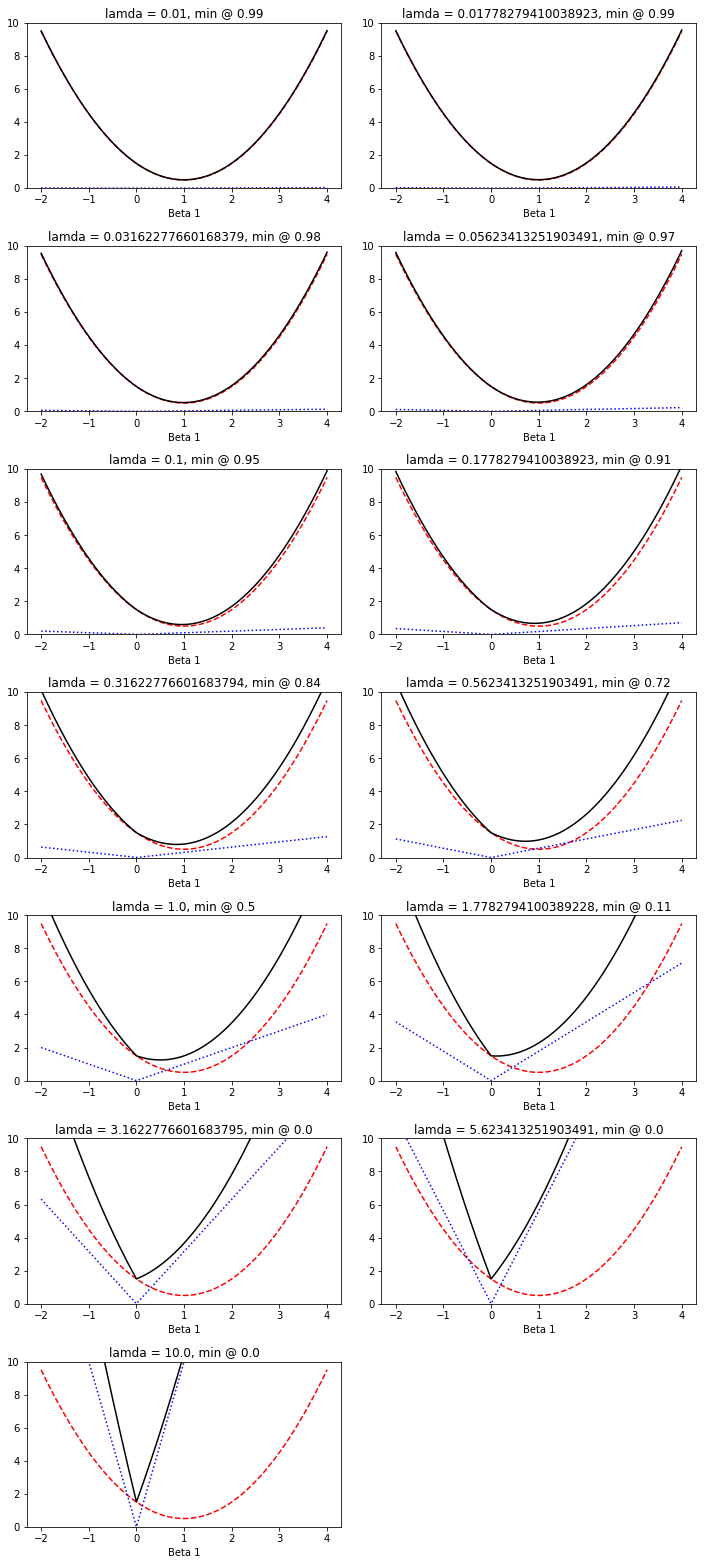

In [10]:
n_subplots=13

mse=(beta-1)**2+.5
plt.figure(1, figsize=(10,40))

for i,lam in enumerate(np.logspace(-2,1,n_subplots),1):
    lasso_penalty=lam*abs(beta)
    lasso_cost=mse+lasso_penalty
    lasso_min=beta[np.argmin(lasso_cost)]

    ax=plt.subplot(n_subplots,2,i)
    ax.set_title('lamda = {}, min @ {:.{prec}}'.format(lam, lasso_min, prec=3))
    ax.plot(beta,mse, c='r', linestyle='--')
    ax.plot(beta,lasso_penalty, c='b', linestyle=':')
    ax.plot(beta,lasso_cost, c='k')
    ax.set_ylim(0,10)
    ax.set_xlabel('Beta 1')
plt.tight_layout()

### Varying lambda to increase Ridge penalty

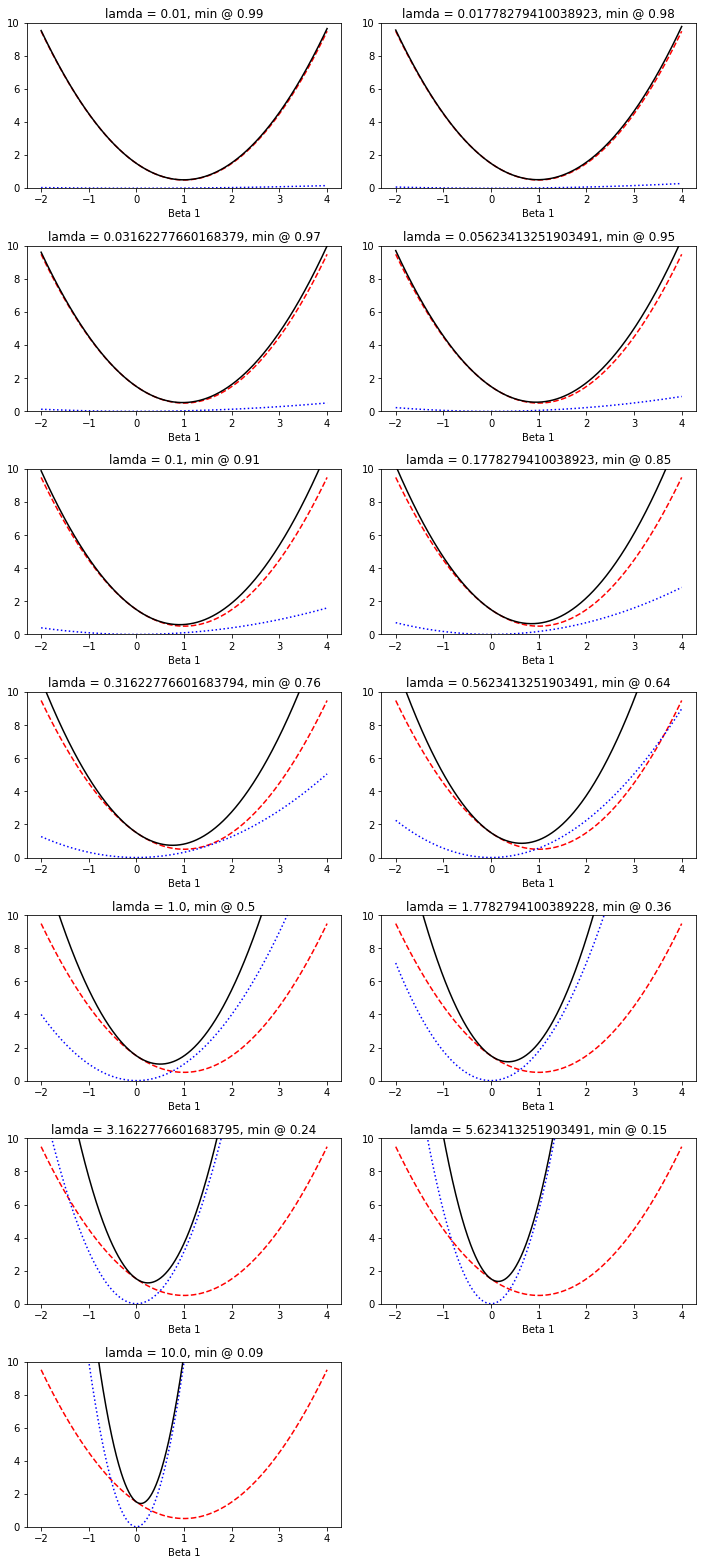

In [11]:
n_subplots=13

mse=(beta-1)**2+.5
plt.figure(1, figsize=(10,40))

for i,lam in enumerate(np.logspace(-2,1,n_subplots),1):
    ridge_penalty=lam*beta**2
    ridge_cost=mse+ridge_penalty
    ridge_min=beta[np.argmin(ridge_cost)]

    ax=plt.subplot(n_subplots,2,i)
    ax.set_title('lamda = {}, min @ {:.{prec}}'.format(lam, ridge_min, prec=3))
    ax.plot(beta,mse, c='r', linestyle='--')
    ax.plot(beta,ridge_penalty, c='b', linestyle=':')
    ax.plot(beta,ridge_cost, c='k')
    ax.set_ylim(0,10)
    ax.set_xlabel('Beta 1')
plt.tight_layout()

### Lasso with "varying" train-error curvature
A nice proxy for Lasso with multiple (9) dimensions

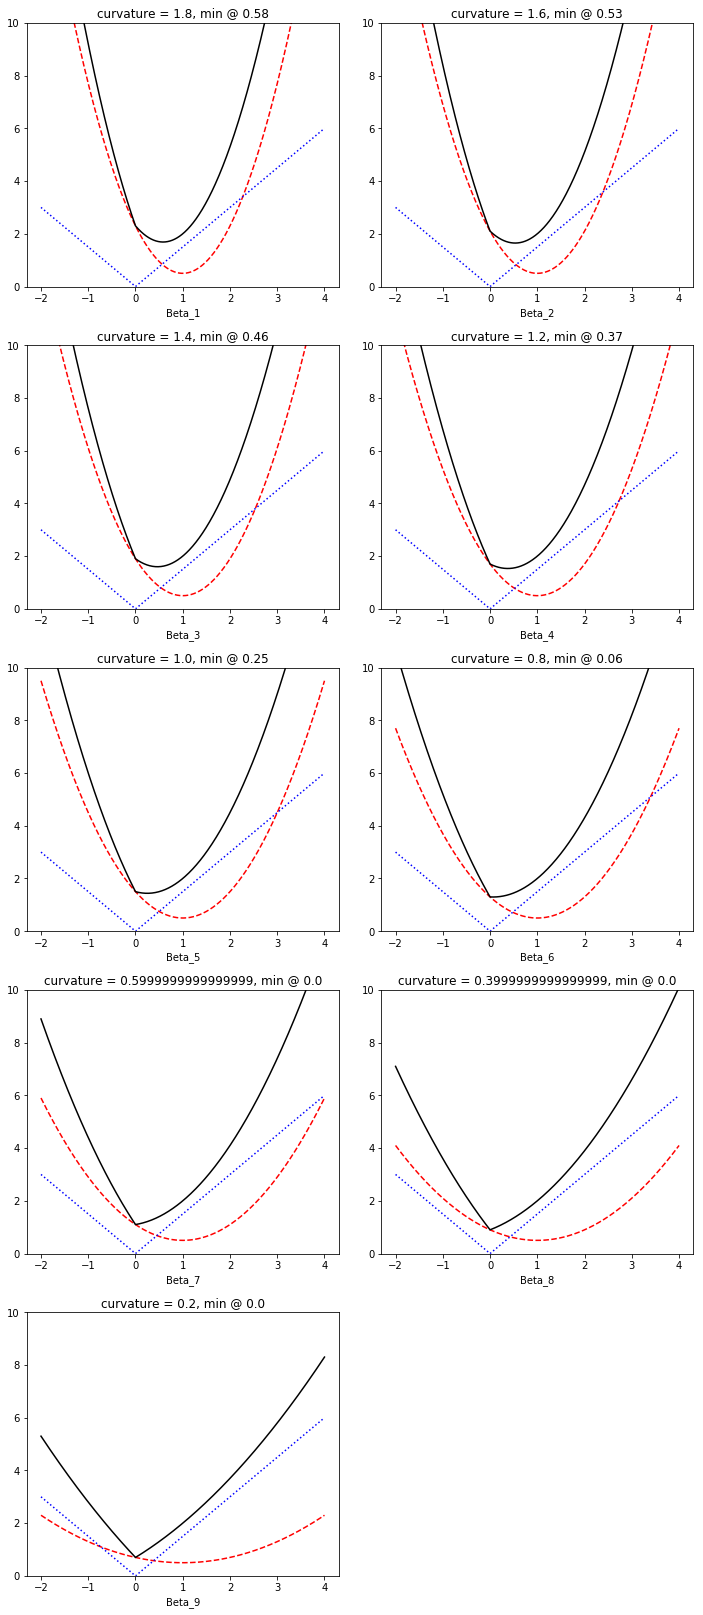

In [12]:
n_subplots=9
lam=1.5 # as taken from above!
lasso_penalty=lam*abs(beta)
plt.figure(1, figsize=(10,40))

for i,curvature in enumerate(np.linspace(1.8,.2,n_subplots),1):
    mse=curvature*(beta-1)**2+.5
    lasso_cost=mse+lasso_penalty
    lasso_min=beta[np.argmin(lasso_cost)]

    ax=plt.subplot(n_subplots,2,i)
    ax.set_title('curvature = {}, min @ {:.{prec}}'.format(curvature, lasso_min, prec=3))
    ax.plot(beta,mse, c='r', linestyle='--')
    ax.plot(beta,lasso_penalty, c='b', linestyle=':')
    ax.plot(beta,lasso_cost, c='k')
    ax.set_ylim(0,10)
    ax.set_xlabel('Beta_{}'.format(i))
plt.tight_layout()

#### 